In [1510]:
# Importing required libraries
import warnings
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plot
import seaborn as sea

# ignore warnings
warnings.filterwarnings('ignore')

In [1511]:
loan= pd.read_csv("loan.csv", low_memory=False)

In [1512]:
loan.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,1077501,1296599,5000,5000,4975.0,36 months,10.65%,162.87,B,B2,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1,1077430,1314167,2500,2500,2500.0,60 months,15.27%,59.83,C,C4,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
2,1077175,1313524,2400,2400,2400.0,36 months,15.96%,84.33,C,C5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
3,1076863,1277178,10000,10000,10000.0,36 months,13.49%,339.31,C,C1,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
4,1075358,1311748,3000,3000,3000.0,60 months,12.69%,67.79,B,B5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN


In [1513]:
loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Columns: 111 entries, id to total_il_high_credit_limit
dtypes: float64(74), int64(13), object(24)
memory usage: 33.6+ MB


In [1514]:
loan.shape

(39717, 111)

In [1515]:
# Print summary of Nulls, Blanks in the dataset
(loan.isnull().sum()/len(loan.index) * 100)

id                              0.000000
member_id                       0.000000
loan_amnt                       0.000000
funded_amnt                     0.000000
funded_amnt_inv                 0.000000
                                 ...    
tax_liens                       0.098195
tot_hi_cred_lim               100.000000
total_bal_ex_mort             100.000000
total_bc_limit                100.000000
total_il_high_credit_limit    100.000000
Length: 111, dtype: float64

In [1516]:
# dropping all loan_status = "Current" rows because they are not useful in deciding defaulted or passed
loan = loan[loan['loan_status'] != "Current"]

In [1517]:
# Dropping columns which is unique id in nature. They dont used for analysis

# Checking if member_id is unique
if len(loan['member_id'].unique()) == loan.shape[0]:
    loan = loan.drop(['member_id'],  axis=1)
else:
    print("not unique")

In [1518]:
# Dropping 'url', 'emp_title', 'desc', 'title', 'sub_grade' columns which not used for analysis
loan = loan.drop(['url', 'emp_title', 'desc', 'title', 'sub_grade'],  axis=1)

In [1519]:
# Drop columns with data captured after loan approval
loan = loan.drop([
    'inq_last_6mths', 'open_acc', 'pub_rec',
    'last_pymnt_amnt', 'last_credit_pull_d',
    'delinq_2yrs', 'earliest_cr_line', 
    'collection_recovery_fee', 'last_pymnt_d', 
    'total_rec_int', 'total_rec_late_fee', 'recoveries', 
    'revol_bal', 'revol_util', 'total_acc', 
    'total_pymnt_inv', 'total_rec_prncp', 
    'out_prncp', 'out_prncp_inv', 'total_pymnt', 'application_type'
],  axis=1)

In [1520]:
# Dropping columns with na values
loan = loan.dropna(axis='columns', how="all")

In [1521]:
# Dropping columns with 0 values
loan = loan.loc[:, (loan != 0).any(axis=0)]

In [1522]:
# drop columns with constant values (ignoring NAs)
def drop_const_cols(df):
    for c in df.columns:
        if df[c].nunique(dropna=True) == 1:
            df = df.drop(c, axis=1)
    return df

# Drop constant columns from the 'loan' dataframe
loan = drop_const_cols(loan)

In [1523]:
# drop columns with more than 65% missing values
def drop_65_cent_empty_cols(df):
    total_rows = len(df)
    for c in df.columns:
        # Drop columns whose mean na values exceed 65%
        if df[c].isna().mean().round(2) >= 0.65:
            df = df.drop(c, axis=1)
    return df
loan = drop_65_cent_empty_cols(loan)

In [1524]:
# Convert the columns loan_amnt and funded_amnt as flot64
loan = loan.astype({'loan_amnt':'float','funded_amnt':'float'})

# Convert the term column into an integer from a string
loan['term'] = loan['term'].apply(lambda x : int(x[:-7]))

# Convert int_rate to  float by removing the "%" character
loan['int_rate'] = loan['int_rate'].apply(lambda x : float(x[:-1]))

# Converting the column issue_d from string object to DateTime
loan['issue_d'] = pd.to_datetime(loan['issue_d'], format='%b-%y')

In [1525]:
# Round off the values to 2 decimal place
for c in ['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate', 'dti']:
    loan[c] = loan[c].apply(lambda x: round(x,2))

In [1526]:
# Convert 'emp_length' to integer values for better statistical analysis
loan['emp_length'] = loan['emp_length'].replace({'< 1 year': 0, '2 years': 2, '3 years': 3, 
                                                         '7 years': 7, '4 years': 4, '5 years': 5, 
                                                         '1 year': 1, '6 years': 6, '8 years': 8, 
                                                         '9 years': 9,  '10+ years': 10})

In [1527]:
# Drop rows with missing 'emp_length' values
loan = loan[loan['emp_length'].notna()]

# Drop rows with missing 'pub_rec_bankruptcies' values
loan = loan[loan['pub_rec_bankruptcies'].notna()]

In [1528]:
loan.columns

Index(['id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'grade', 'emp_length', 'home_ownership', 'annual_inc',
       'verification_status', 'issue_d', 'loan_status', 'purpose', 'zip_code',
       'addr_state', 'dti', 'pub_rec_bankruptcies'],
      dtype='object')

In [1529]:
# Column titles for plots and charts
columns_names = {
    'loan_amnt': 'Loan Amount',
    'funded_amnt': 'Funded Amount',
    'funded_amnt_inv': 'Funded Amount Investors',
    'term': 'Loan Term',
    'int_rate': 'Interest Rate',
    'installment': 'Installment',
    'grade': 'Grade',
    'emp_length': 'Employment Length',
    'home_ownership': 'Home Owner Status',
    'annual_inc': 'Annual Income', 
    'verification_status': 'Verification Status',
    'issue_d': 'Issue Date',
    'loan_status': 'Loan Status',
    'purpose': 'Purpose of Loan',
    'addr_state': 'State',
    'dti': 'Debt To Income Ratio',
    'pub_rec_bankruptcies': 'Bankruptcies Record'
}

In [1530]:
def uni_variate_fun(data_frame, column_name):
    # Create a figure with 2 subplots: one for the distribution plot and one for the box plot
    fig, p = plot.subplots(1, 2, figsize=(16, 4))
    
    # Plot the distribution of the specified column_name, showing both the histogram and KDE
    sea.distplot(data_frame.loc[data_frame[column_name].notnull(), column_name], kde=True, hist=True, ax=p[0])
    
    # Plot a boxplot of the specified column_name to visualize its spread and outliers
    sea.boxplot(x=column_name, data=data_frame, ax=p[1])
    
    # Set the x-axis labels using the corresponding column_name title from the dictionary
    p[0].set_xlabel(columns_names[column_name])
    p[1].set_xlabel(columns_names[column_name])
    
    # Adjust the layout to prevent overlapping of plots
    plot.tight_layout()
    
    # Display the plots
    plot.show()


In [1531]:
# calculate the ratio of Charged Off loans against Fully Paid loans for a given column_name
def comparision(data_frame, column_name):
    # Create a pivot table to count 'Charged Off' and 'Fully Paid' loans for each unique value in the column_name
    comparision_df = data_frame.pivot_table(index=column_name, columns='loan_status', values='id', aggfunc=len).reset_index()
    
    # Calculate the total number of loans for each unique value in the column_name
    comparision_df['total'] = comparision_df['Charged Off'] + comparision_df['Fully Paid']
    
    # Calculate the ratio of 'Charged Off' loans as a percentage of the total
    comparision_df['charge_off_ratio'] = round(comparision_df['Charged Off'] / comparision_df['total'] * 100)
    
    # Sort the values by the total number of loans in descending order
    comparision_df.sort_values(by='total', ascending=False)
    
    # Return the DataFrame with the calculated ratios
    return comparision_df

# plot the charge-off ratio for a specific column
def comparision_chart(df, column_name, invert=False):
    plot.figure(figsize=[20, 8])
    plot.title('Charged Off : ' + columns_names[column_name])
    
    # Calculate the charge-off ratio using the ratio_wise function
    comparision_df = comparision(df, column_name)
    
    # Plot the charge-off ratio; invert the axes if specified
    if invert:
        sea.barplot(x='charge_off_ratio', y=column_name, data=comparision_df)
    else:
        sea.barplot(x=column_name, y='charge_off_ratio', data=comparision_df)
    
    # Adjust the layout to prevent overlapping
    plot.tight_layout()
    
    # Display the plot
    plot.show()
    
    # Return the DataFrame with the calculated ratios
    return comparision_df

# bar plot for a specified column, with optional annotations
def bi_variate_func(df, column, hue=None, annot=1):
        temp = pd.Series()  # Placeholder for a temporary series
        fig, ax = plot.subplots(figsize=(20, 14))
        
        # Adjust figure width based on the number of unique values in the column
        width = len(df[column].unique()) + 6 + 4 * len(temp.unique())
        fig.set_size_inches(width, 7)
        
        # Create a count plot for the specified column, optionally grouped by a hue variable
        ax = sea.countplot(data=df, x=column, order=df[column].value_counts().index, hue=hue)
        
        # Add annotations to the bars if specified
        if annot == 1:
            for p in ax.patches:
                ax.annotate('{:1.1f}%'.format((p.get_height()*100)/float(len(df))), (p.get_x()+0.05, p.get_height()+20))  
        elif annot == 2:
            for p in ax.patches:
                ax.annotate(p.get_height(), (p.get_x()+0.32, p.get_height()+20))
        
        del temp  # Delete the temporary series
        plot.show()  # Display the plot


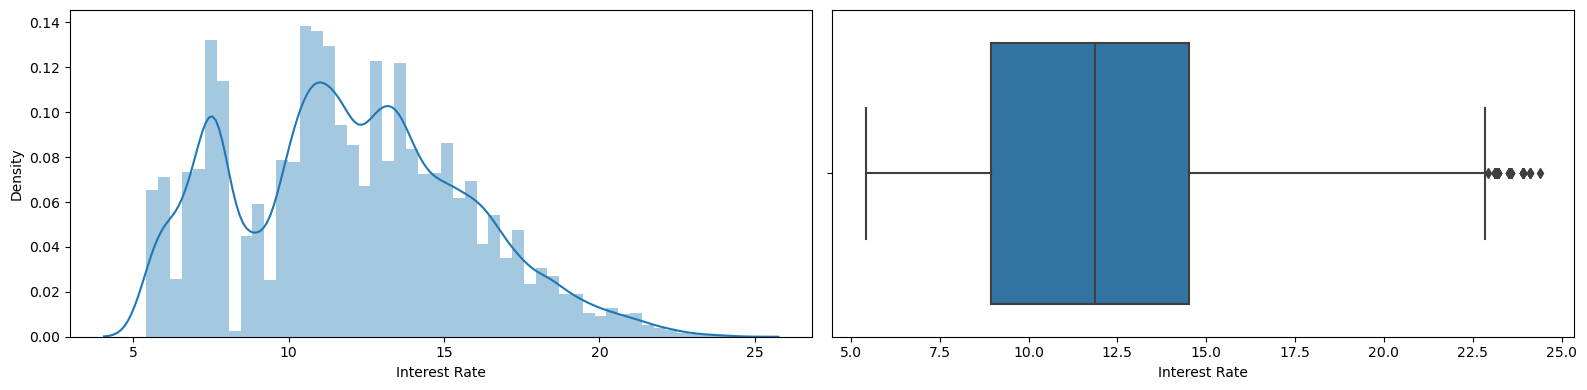

In [1532]:
uni_variate_fun(loan, 'int_rate')

# Majority of the interest rate is in the range of 5% to 16% going at the max to 22.5%

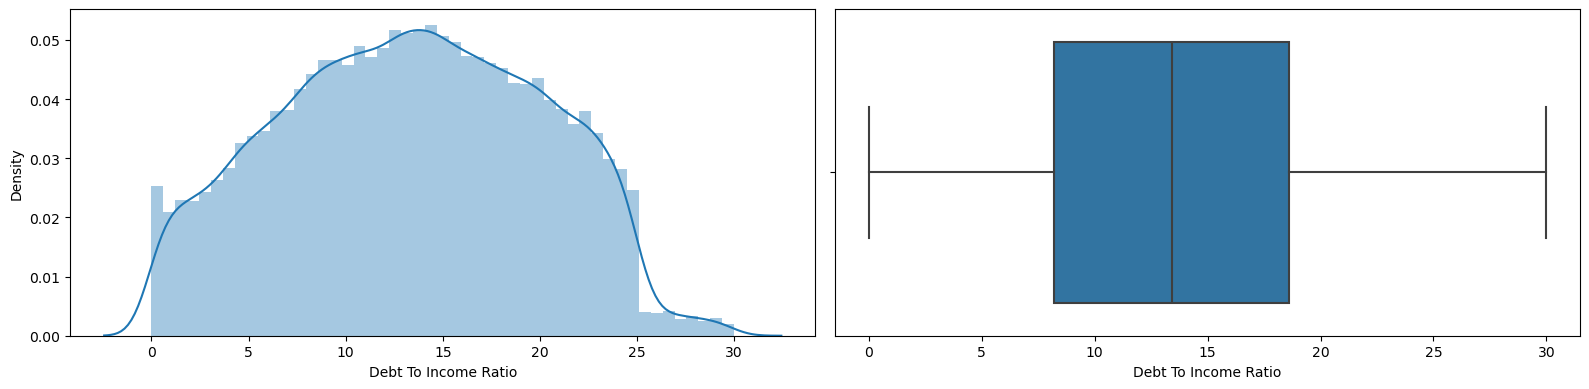

In [1533]:
uni_variate_fun(loan, 'dti')

# Majority of the debt to income is in the range of 10 to 20 going at the max to 30

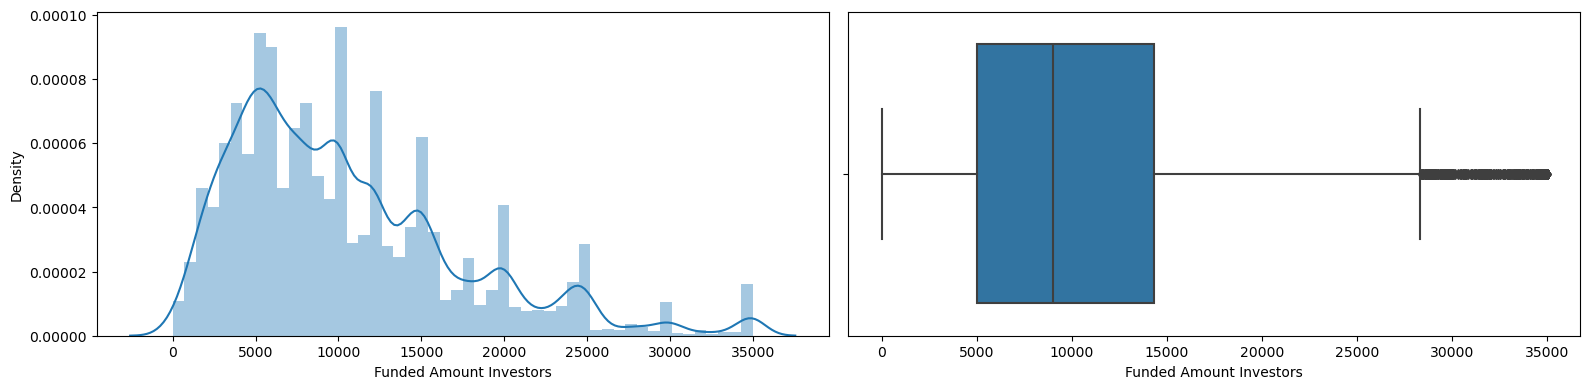

In [1534]:
uni_variate_fun(loan, 'funded_amnt_inv')

# Majority of the funded_amnt_inv is in the range of 5K to 12K

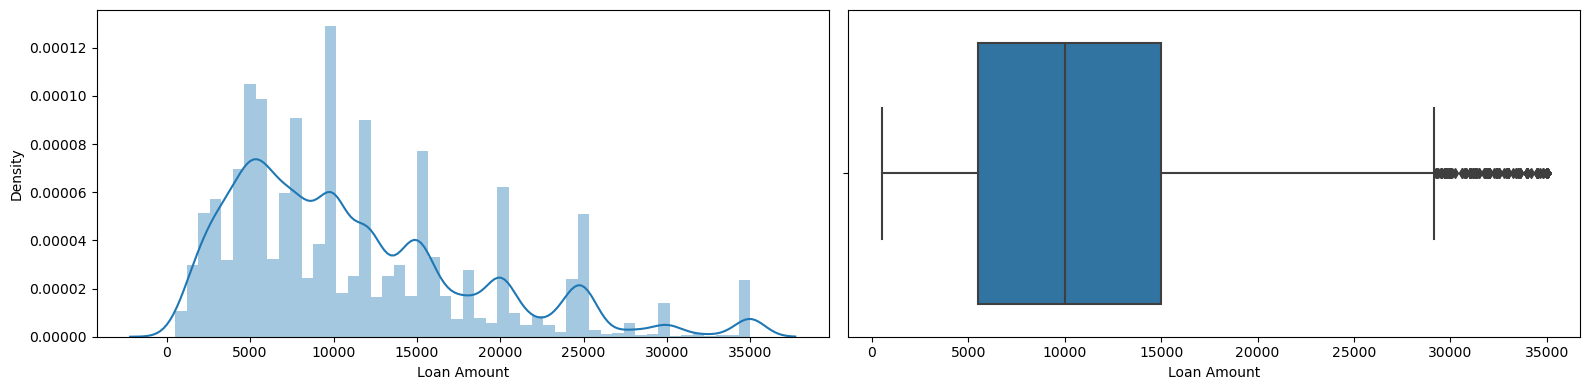

In [1535]:
uni_variate_fun(loan, 'loan_amnt')

# Majority of the loan_amount is in the range of 5K to 14K

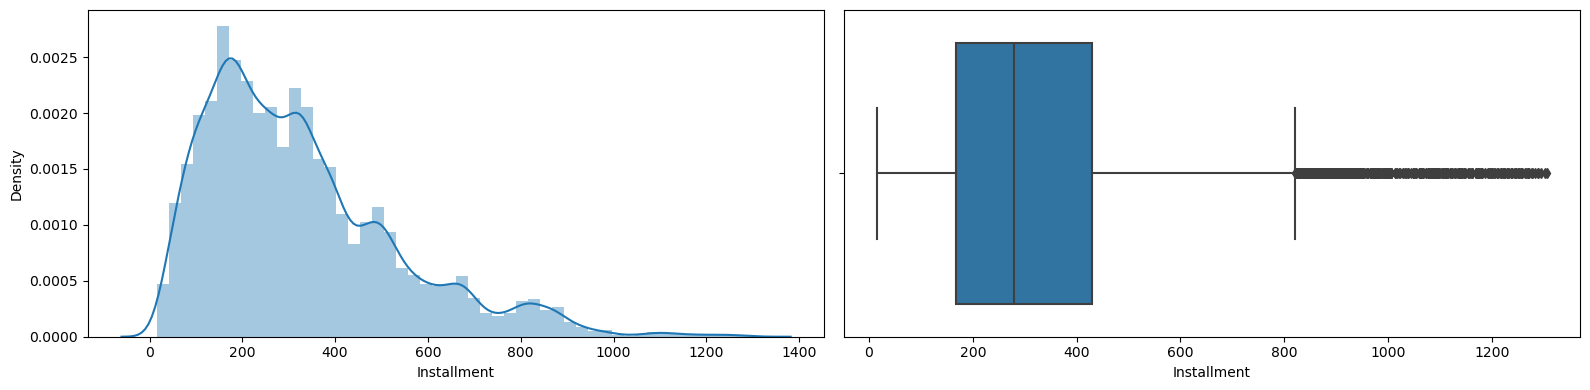

In [1536]:
uni_variate_fun(loan, 'installment')

# Majority of the installment is in the range of 20 to 400 going at the max to 700

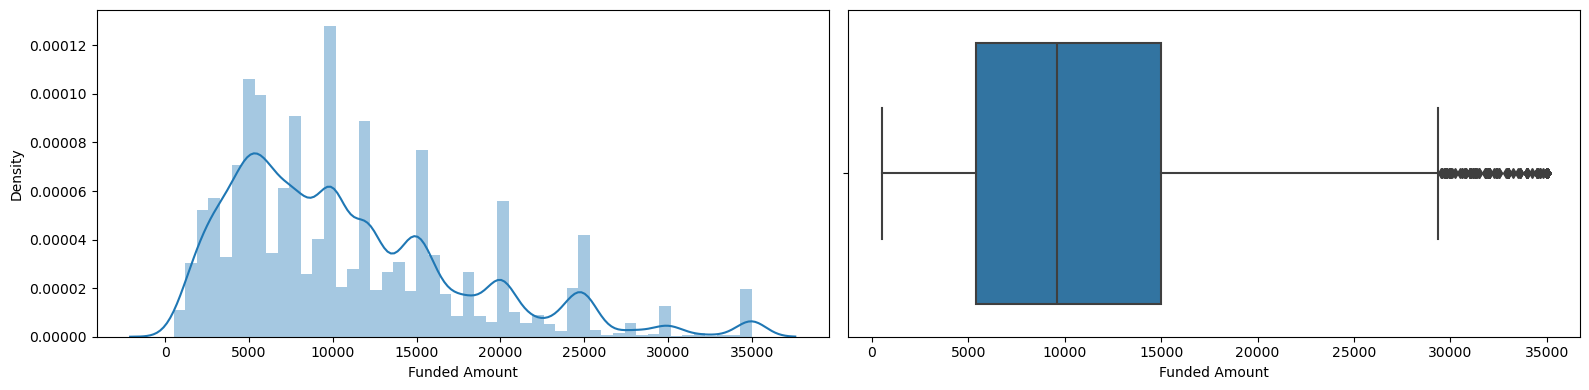

In [1537]:
uni_variate_fun(loan, 'funded_amnt')

# Majority of the funded_amnt is in the range of 5K to 13K

<Axes: xlabel='emp_length'>

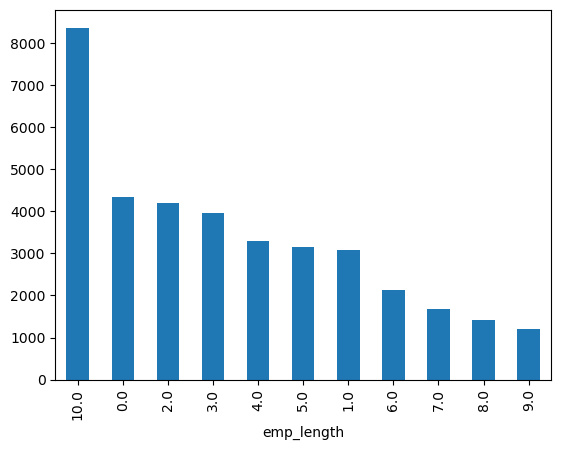

In [1538]:
loan['emp_length'].value_counts().plot.bar()

# Majority of the employment length of the customers are 10+ years and then in the range of 0-3 years

<Axes: xlabel='term'>

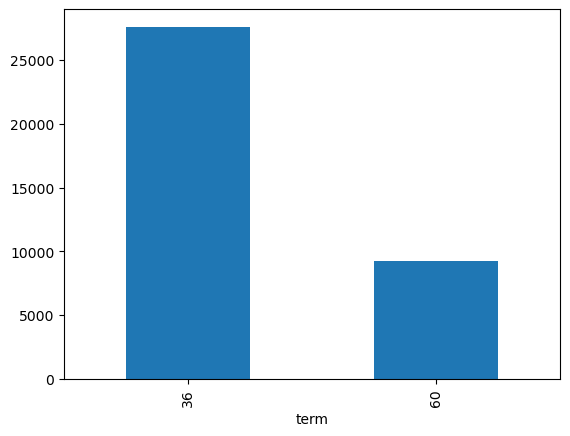

In [1539]:
loan['term'].value_counts().plot.bar()

# Majority of the loan applications counts are in the term of 36 months.

<Axes: xlabel='pub_rec_bankruptcies'>

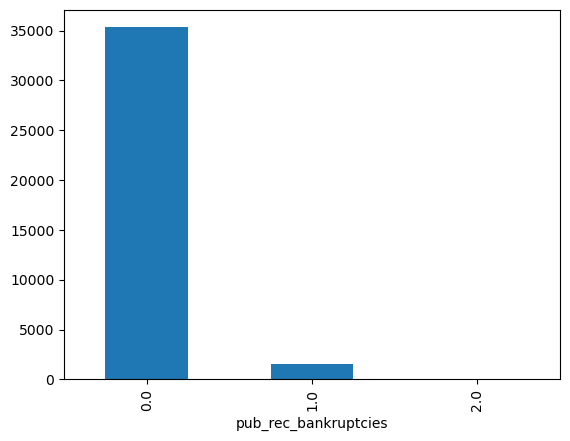

In [1540]:
loan['pub_rec_bankruptcies'].value_counts().plot.bar()

# Majority of the loan applicants are in the category of not having an public record of bankruptcies

<Axes: xlabel='purpose'>

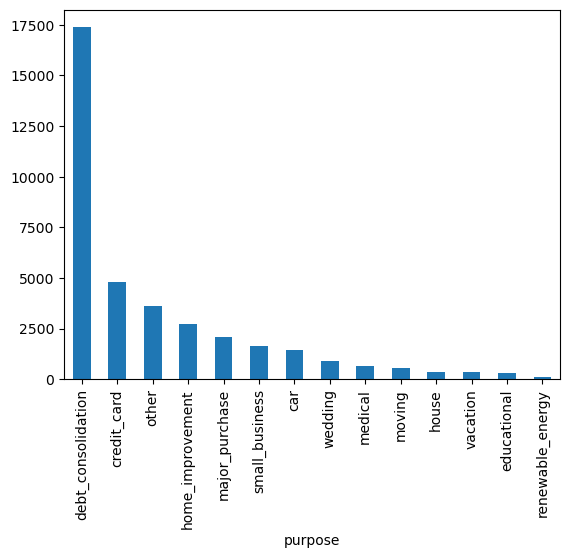

In [1541]:
loan['purpose'].value_counts().plot.bar()

# Majority of loan application are in the category of debt_consolidation

<Axes: xlabel='grade'>

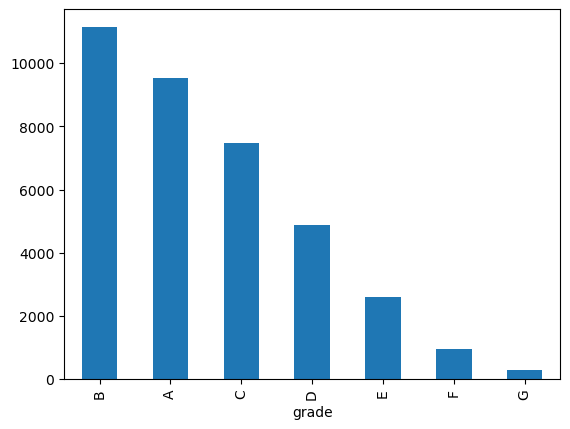

In [1542]:
loan['grade'].value_counts().plot.bar()

# Majority of loan application counts fall under the catogory of Grade B and A

<Axes: xlabel='home_ownership'>

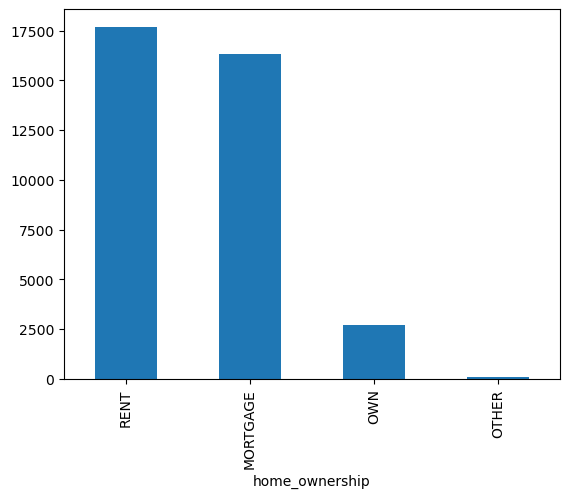

In [1543]:
loan['home_ownership'].value_counts().plot.bar()

# Majority of the home owner status are in status of RENT and MORTGAGE

<Axes: xlabel='addr_state'>

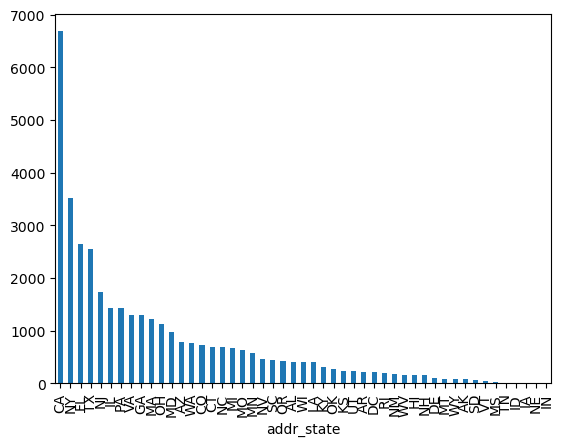

In [1544]:
loan['addr_state'].value_counts().plot.bar()

# CA state has the maximum amount of loan applications

## Summary of Univariate Analysis

1. Most loan applicants earn between 0 and 40,000 annually.
2. The majority have a debt-to-income ratio between 0 and 20, with a few going up to 30.
3. Most people in the dataset are either renting their homes or have a mortgage.
4. The most common reason for loan applications is debt consolidation.
5. California has the highest number of loan applications.
6. Most applicants do not have a public record of bankruptcies.
7. The majority of applicants have either over 10 years or between 0-2 years of employment.
1. The most frequent loan amounts are between 5,000 and 10,000.
2. Most interest rates range from 5% to 16%, with a few going up to 22%.
3. The typical installment amount is around $20.
4. Most loans are applied for with a term of 36 months.
5. Most loans fall into Grade B.
1. Understanding customer demographics helps identify the most promising segments for targeting loan applications.
2. Further analysis is needed to explore why some categories have lower application rates compared to others.


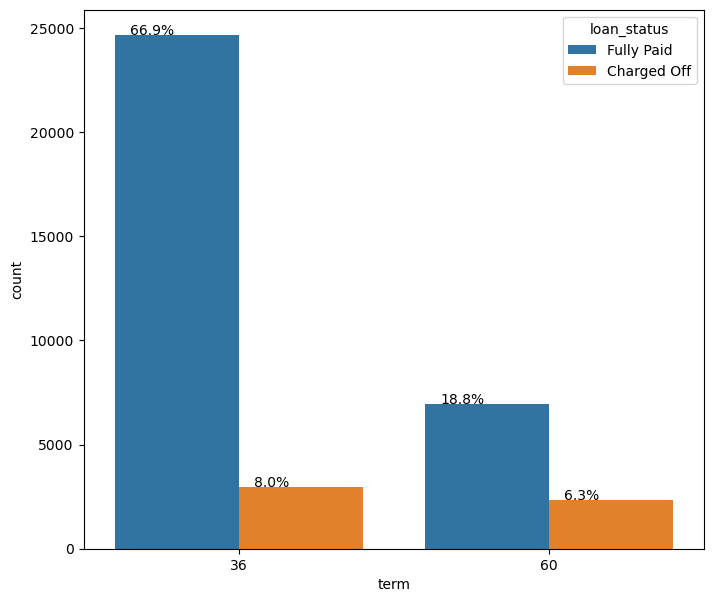

In [1546]:
# Overall ratio of Charge Offs
bi_variate_func(loan, 'term', 'loan_status')

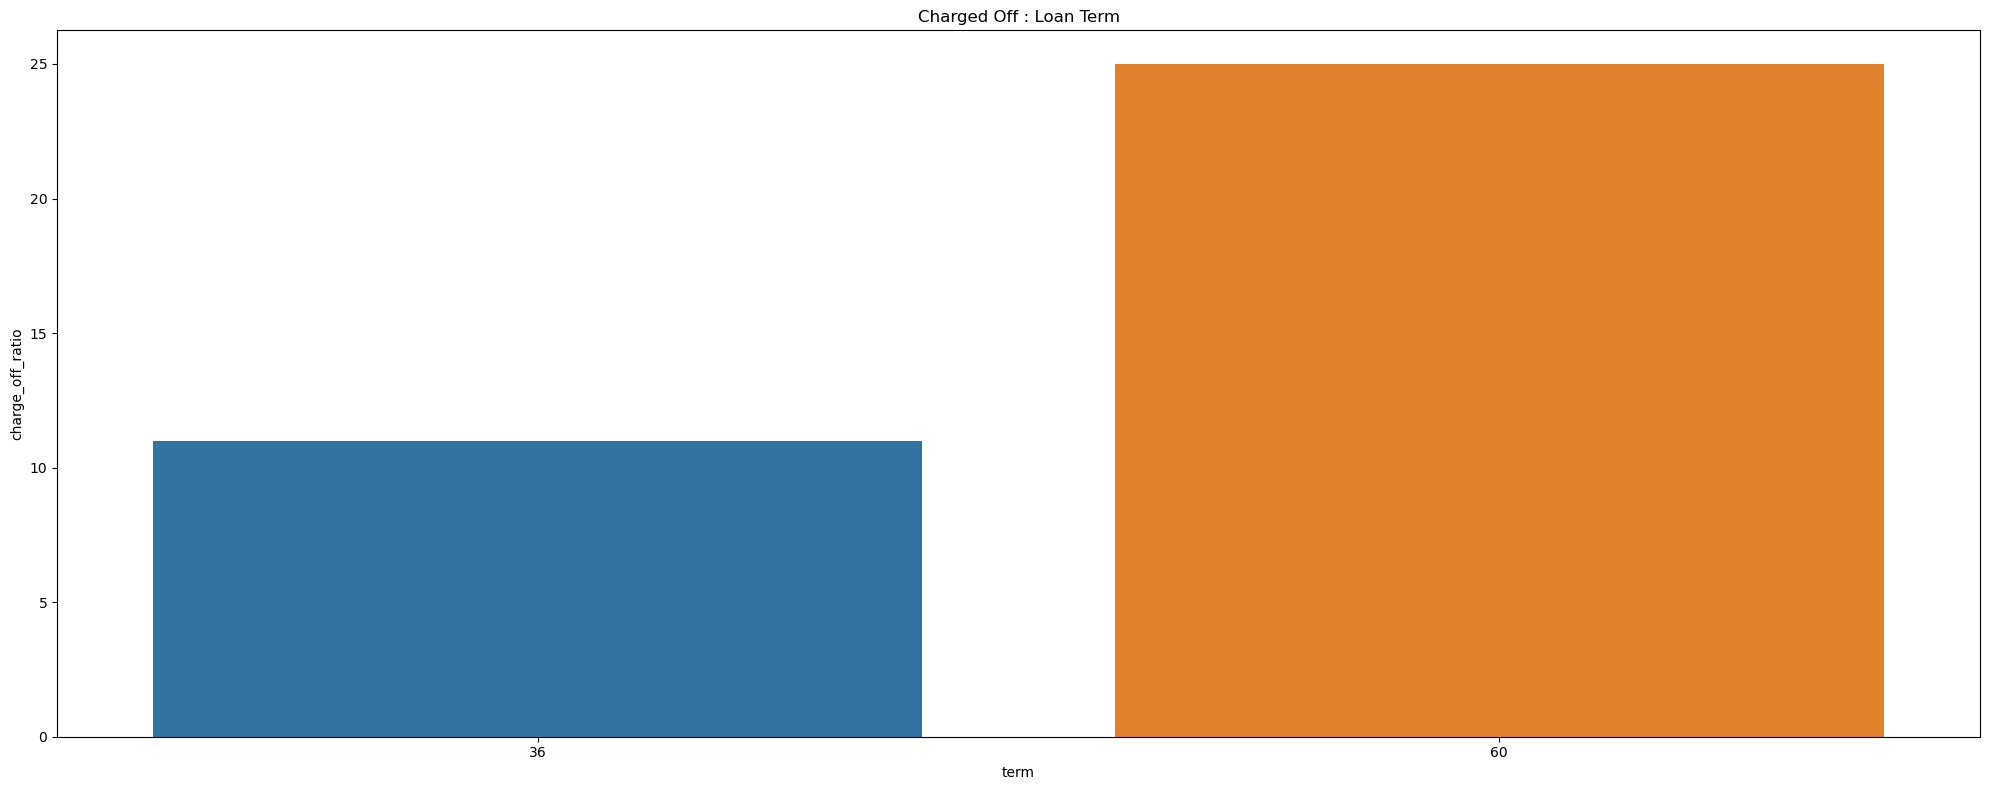

loan_status,term,Charged Off,Fully Paid,total,charge_off_ratio
0,36,2955,24635,27590,11.0
1,60,2326,6931,9257,25.0


In [1547]:
## The ratio of Charge Offs within the category
comparision_chart(loan, 'term')

# The majority of loan applications are for a term of 36 months.
# The overall percentage of charge-offs is slightly higher for loans with a term of 36 months (8%) compared to those with a term of 60 months (6%).
# However, when calculating the ratio of charge-offs within each term category, the ratio is significantly higher for loans with a term of 60 months (25%) compared to those with a term of 36 months (10%).
# Therefore, loans with a term of 60 months should be scrutinized more carefully.
# Applicants with a 60-month loan term are more likely to experience higher charge-offs.


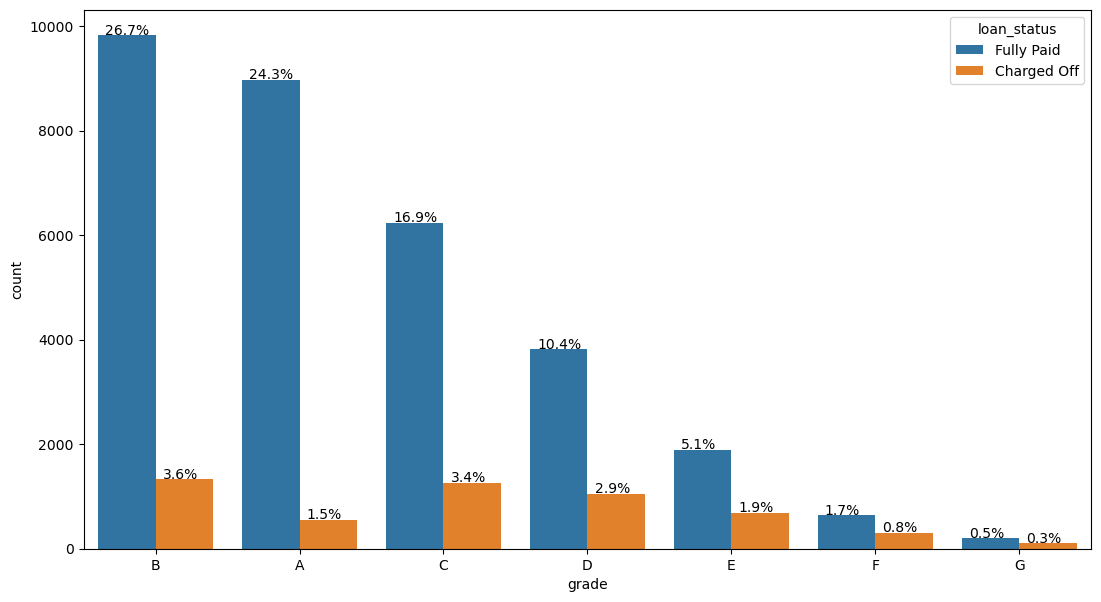

In [1548]:
# Overall ratio of Charge Offs against the total
bi_variate_func(loan, 'grade', 'loan_status')

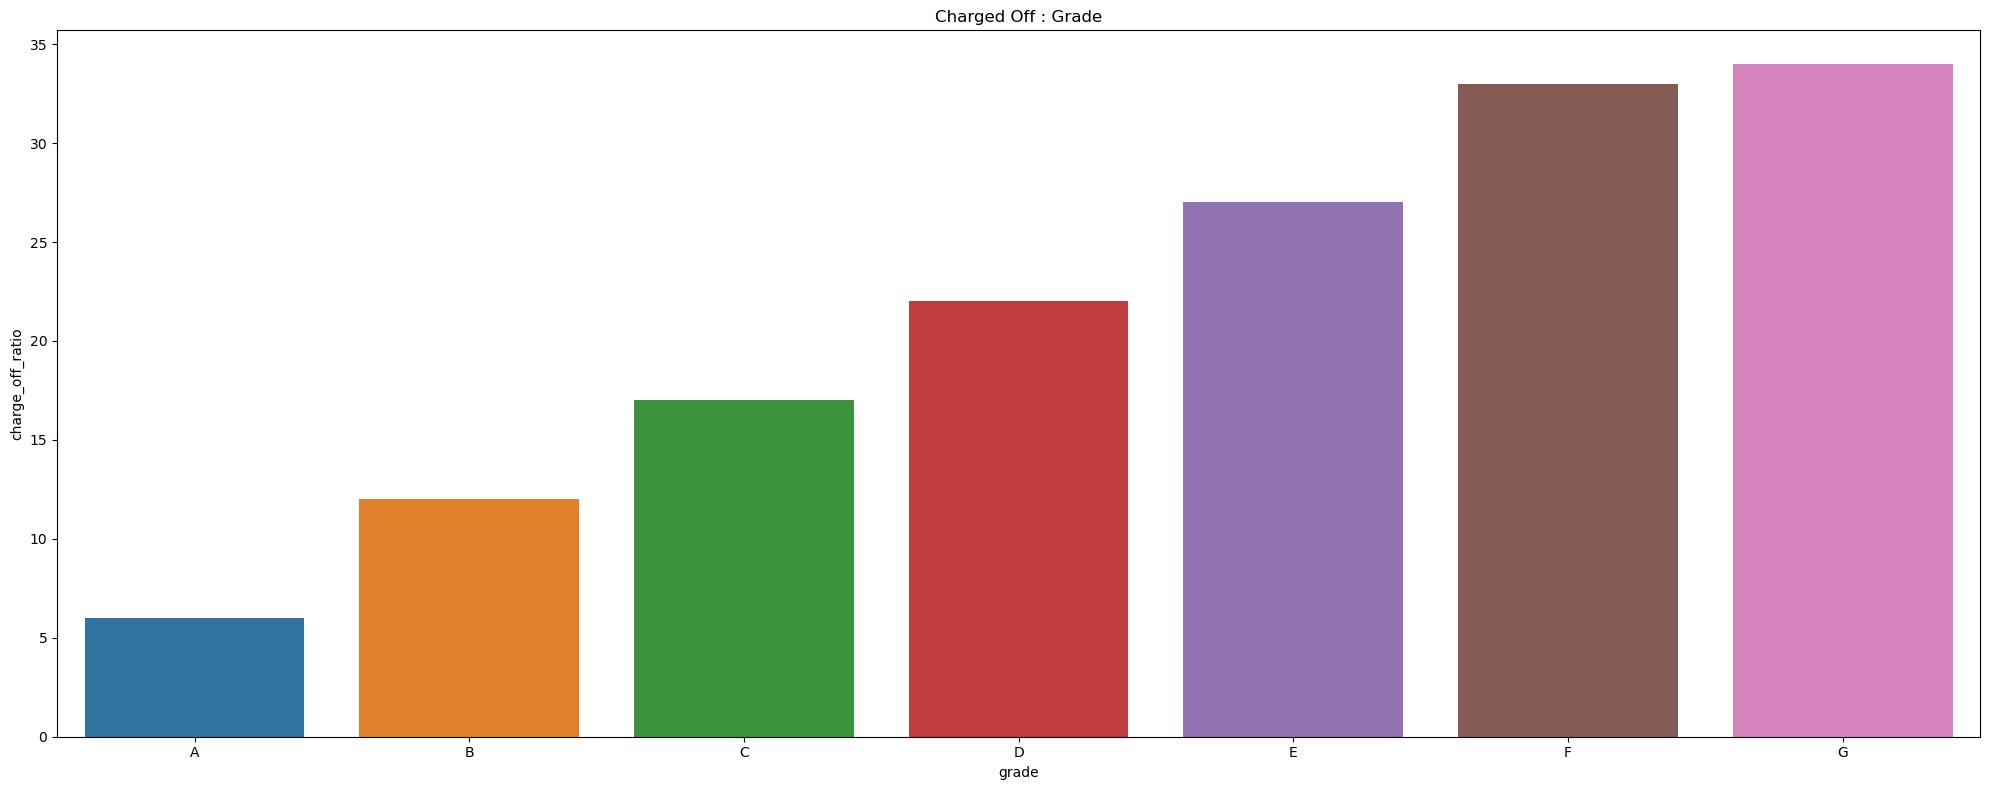

loan_status,grade,Charged Off,Fully Paid,total,charge_off_ratio
0,A,552,8966,9518,6.0
1,B,1326,9824,11150,12.0
2,C,1254,6232,7486,17.0
3,D,1052,3816,4868,22.0
4,E,690,1895,2585,27.0
5,F,307,637,944,33.0
6,G,100,196,296,34.0


In [1549]:
## The ratio of Charge Offs within the category total
comparision_chart(loan, 'grade')

# The majority of loan volume is categorized as Grade B.
# The highest percentages of overall charge-offs are found in Grades B (3.7%) and C (3.6%).
# When analyzing the charge-off ratio within each grade, the highest percentage of charge-offs is observed in Grade G.
# The largest clusters of charge-offs are in Grades G and F, both exceeding 30%.
# However, the volume of loans in Grade G is very low (158), so it does not significantly impact the overall risk.
# The highest risk of charge-offs is associated with Grades B and C.
# Grades F and G have a very high likelihood of charge-offs, although their loan volumes are low.
# Grade A has a very low likelihood of charge-offs.
# The probability of charge-offs increases from Grade A to Grade G.

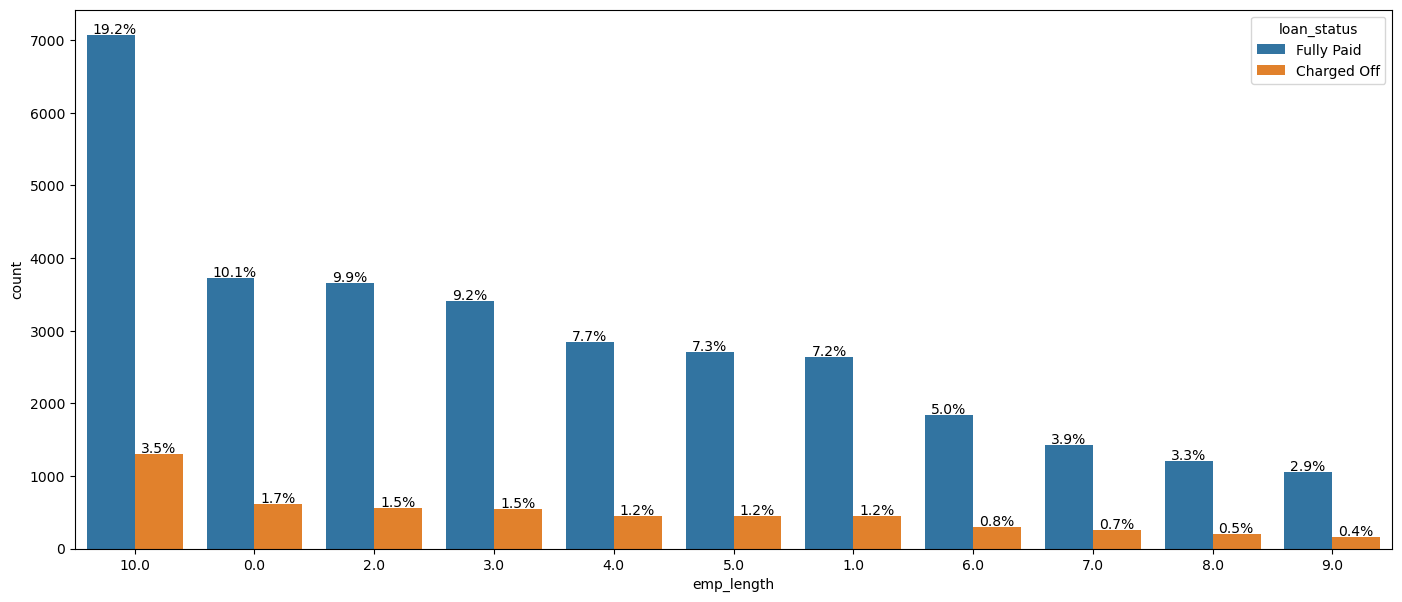

In [1550]:
# Overall ratio of Charge Offs against the total
bi_variate_func(loan, 'emp_length', 'loan_status')

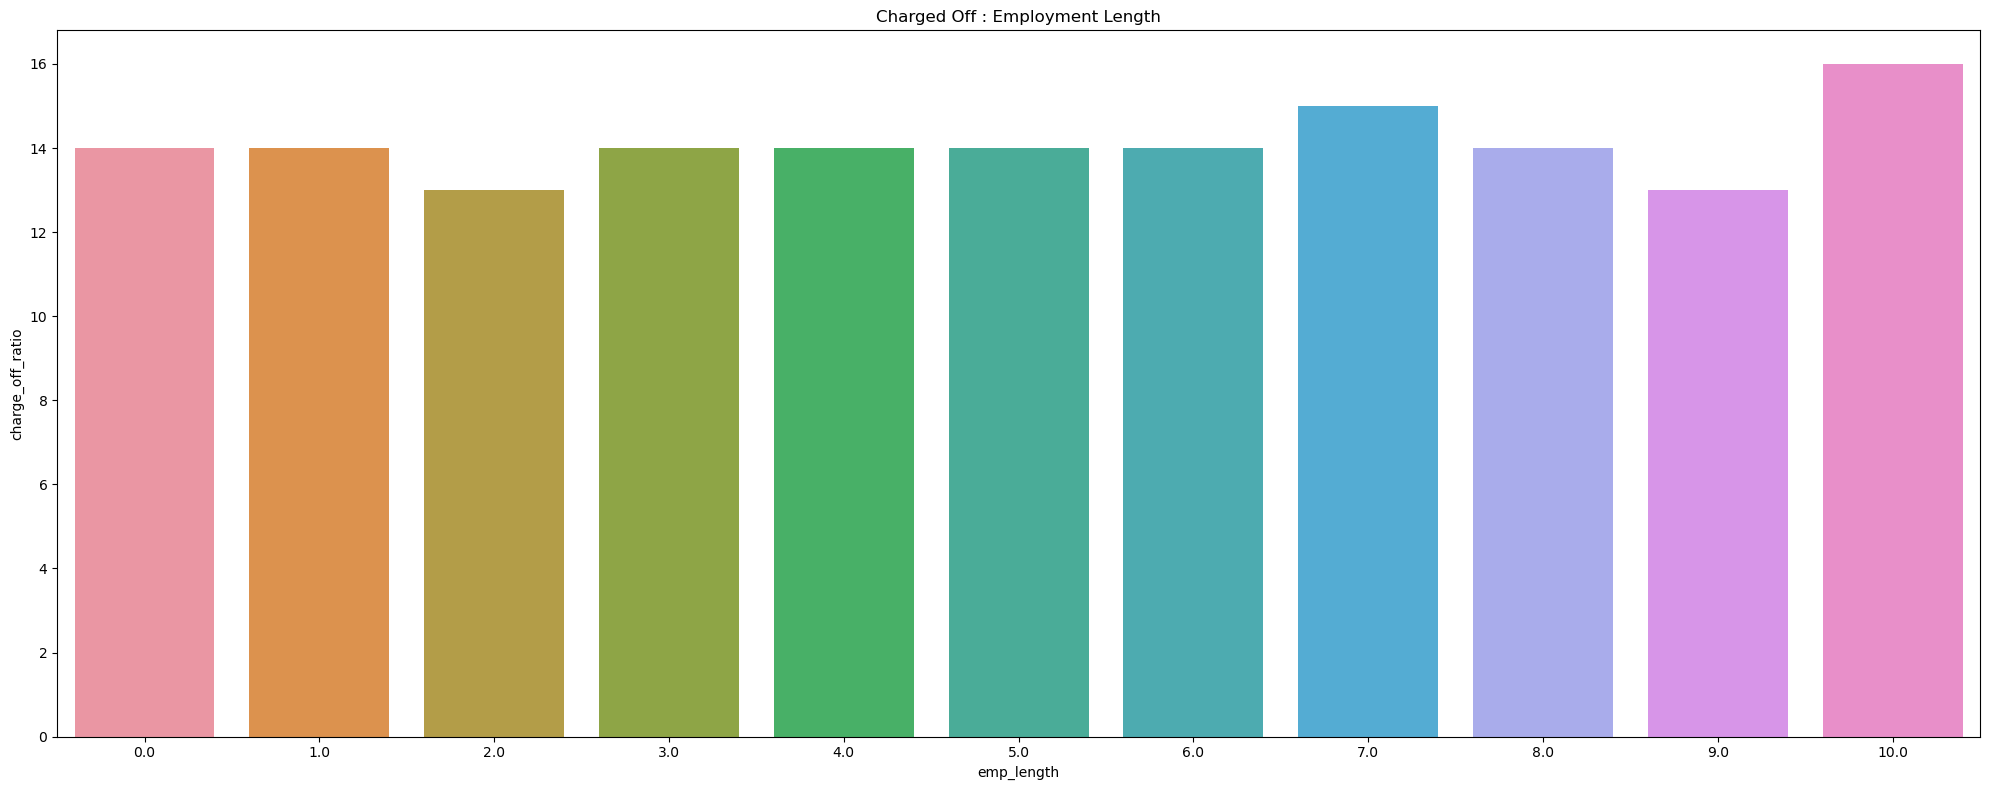

loan_status,emp_length,Charged Off,Fully Paid,total,charge_off_ratio
0,0.0,612,3729,4341,14.0
1,1.0,442,2635,3077,14.0
2,2.0,556,3651,4207,13.0
3,3.0,549,3402,3951,14.0
4,4.0,450,2847,3297,14.0
5,5.0,454,2707,3161,14.0
6,6.0,301,1835,2136,14.0
7,7.0,258,1431,1689,15.0
8,8.0,200,1210,1410,14.0
9,9.0,156,1053,1209,13.0


In [1551]:
## The ratio of Charge Offs within the category total
comparision_chart(loan, 'emp_length')

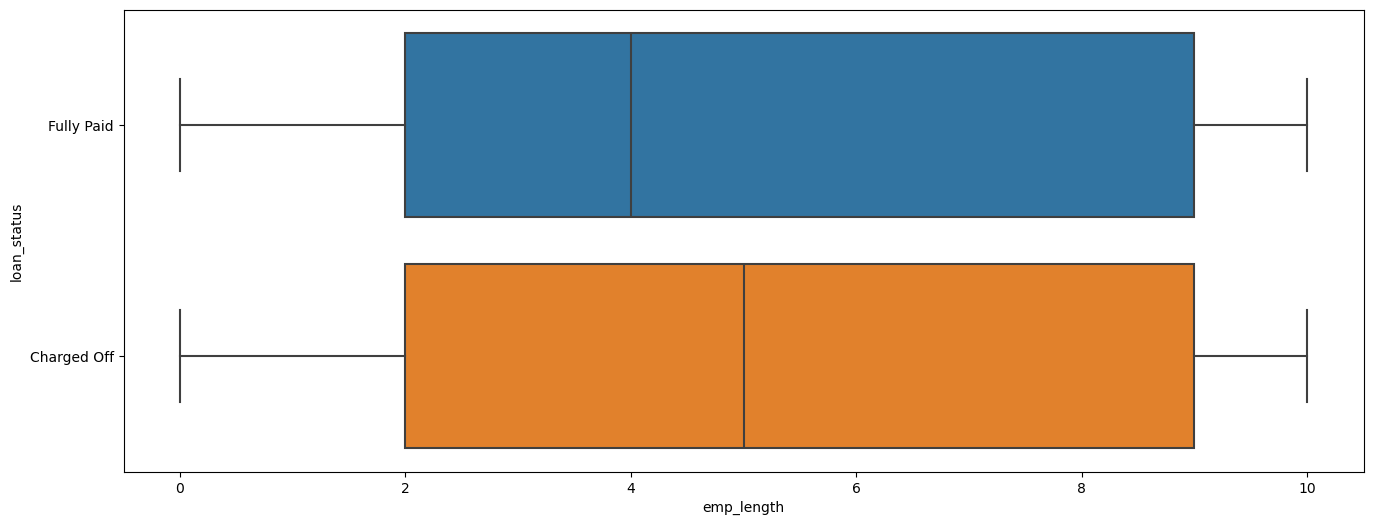

In [1552]:
plot.figure(figsize=(16,6))
sea.boxplot(y=loan.loan_status,x=loan.emp_length)
plot.show()

# The highest number of charge-offs is observed among employees with 10 years or more of tenure.
# The charge-off ratios within different employee length categories are similar and do not provide clear conclusions.
# The greatest number of charge-offs is seen among employees with 10 years or more of employment.
# There is a high probability of charge-offs for individuals with an income range of less than 1 year.
# The charge-off ratios within different income ranges are quite similar and inconclusive.

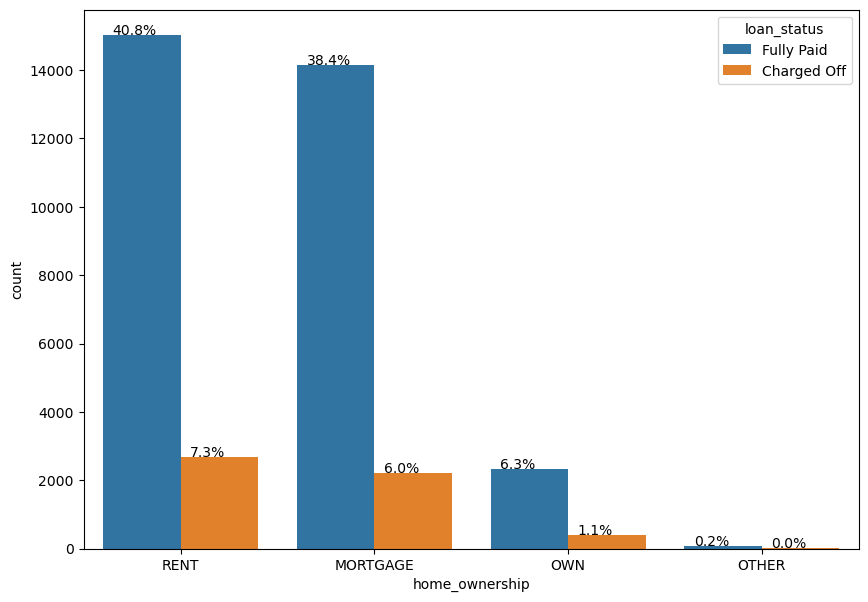

In [1553]:
# Overall ratio of Charge Offs against the total
bi_variate_func(loan, 'home_ownership', 'loan_status')

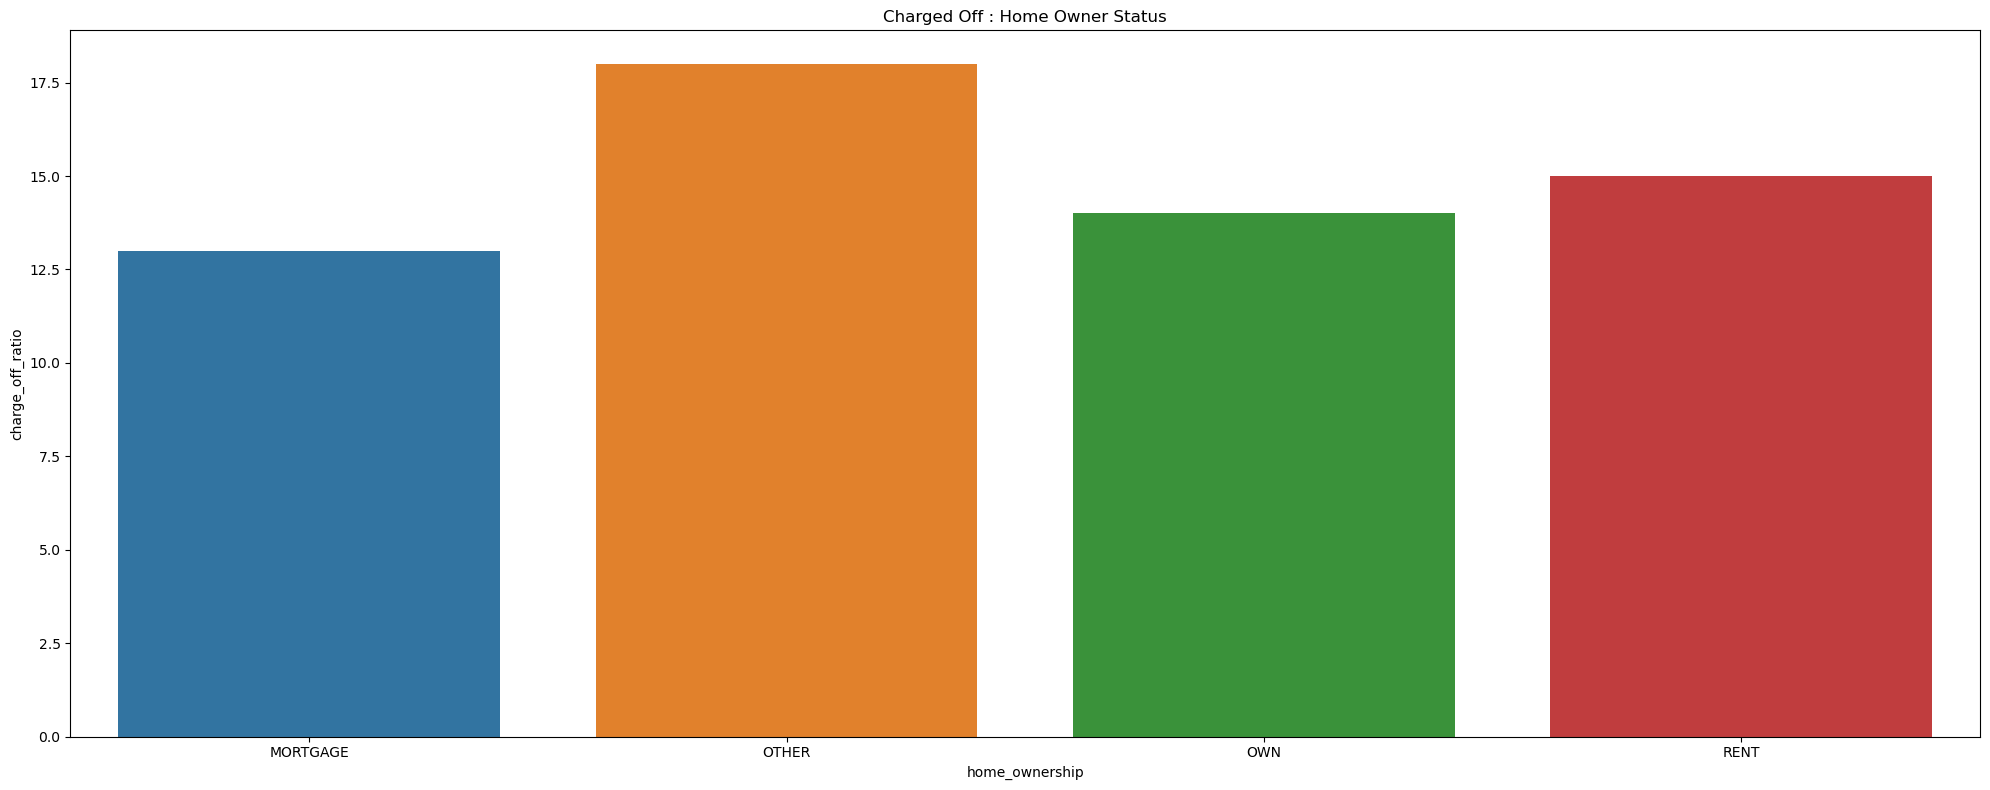

loan_status,home_ownership,Charged Off,Fully Paid,total,charge_off_ratio
0,MORTGAGE,2199,14144,16343,13.0
1,OTHER,18,80,98,18.0
2,OWN,387,2321,2708,14.0
3,RENT,2677,15021,17698,15.0


In [1554]:
## The ratio of Charge Offs within the category total
comparision_chart(loan, 'home_ownership')

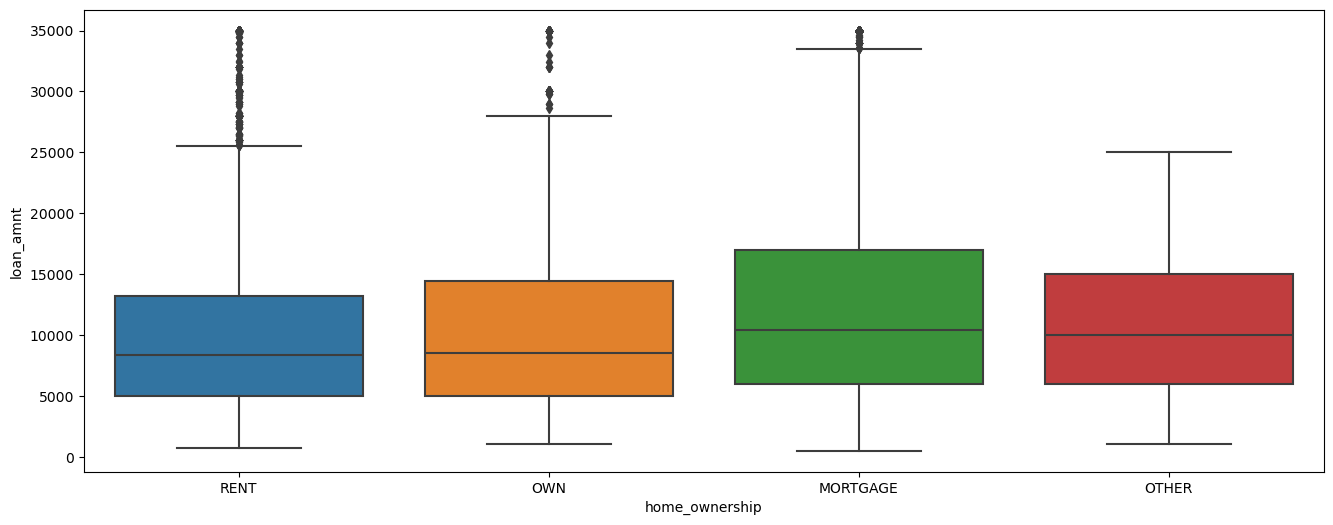

In [1555]:
plot.figure(figsize=(16,6))
sea.boxplot(y=loan.loan_amnt,x=loan.home_ownership)
plot.show()

# The highest number of charge-offs is observed in the categories of RENT and MORTGAGE.
# Within each home ownership category, the charge-off ratio is highest for the "Other" category.
# Individuals with a home ownership status of MORTGAGE are at the highest risk for charge-offs.
# The MORTGAGE category also includes a wide range of loan amounts, which further increases the risk of charge-offs.                                                          

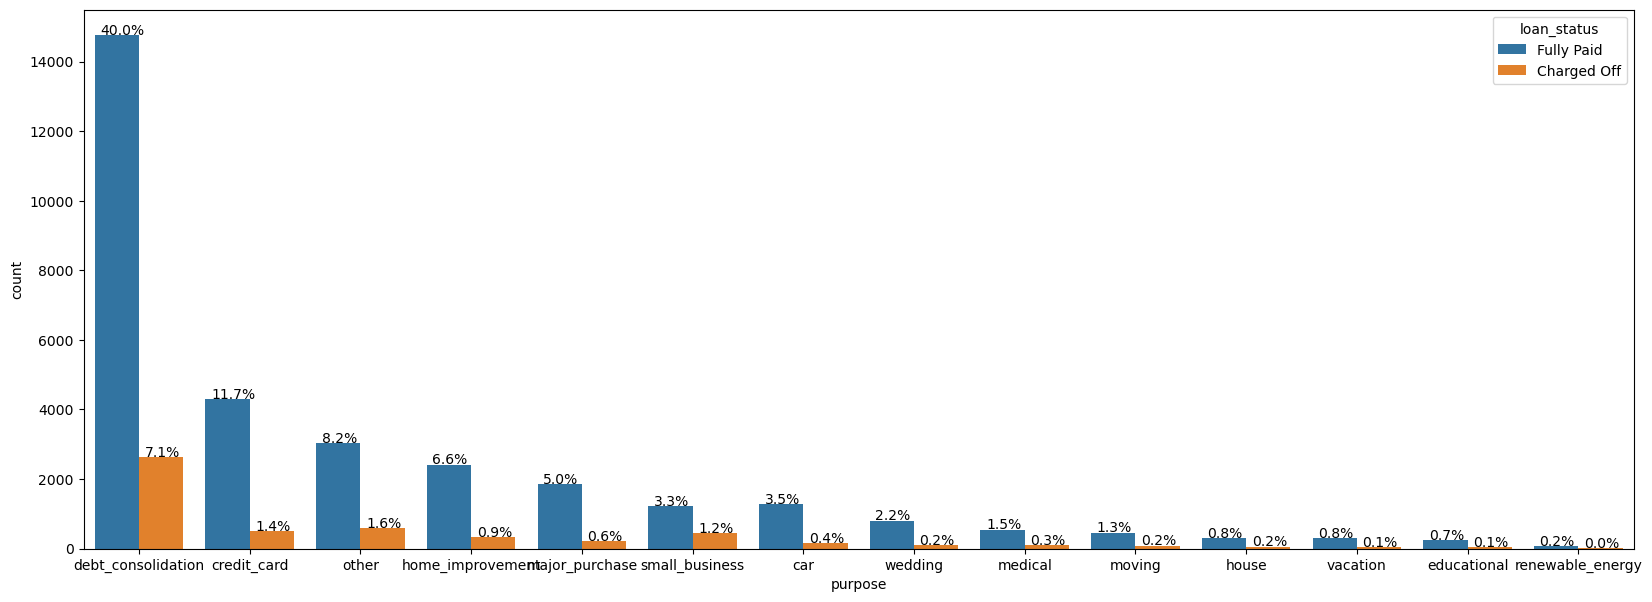

In [1556]:
# Overall ratio of Charge Offs against the total
bi_variate_func(loan, 'purpose', 'loan_status')

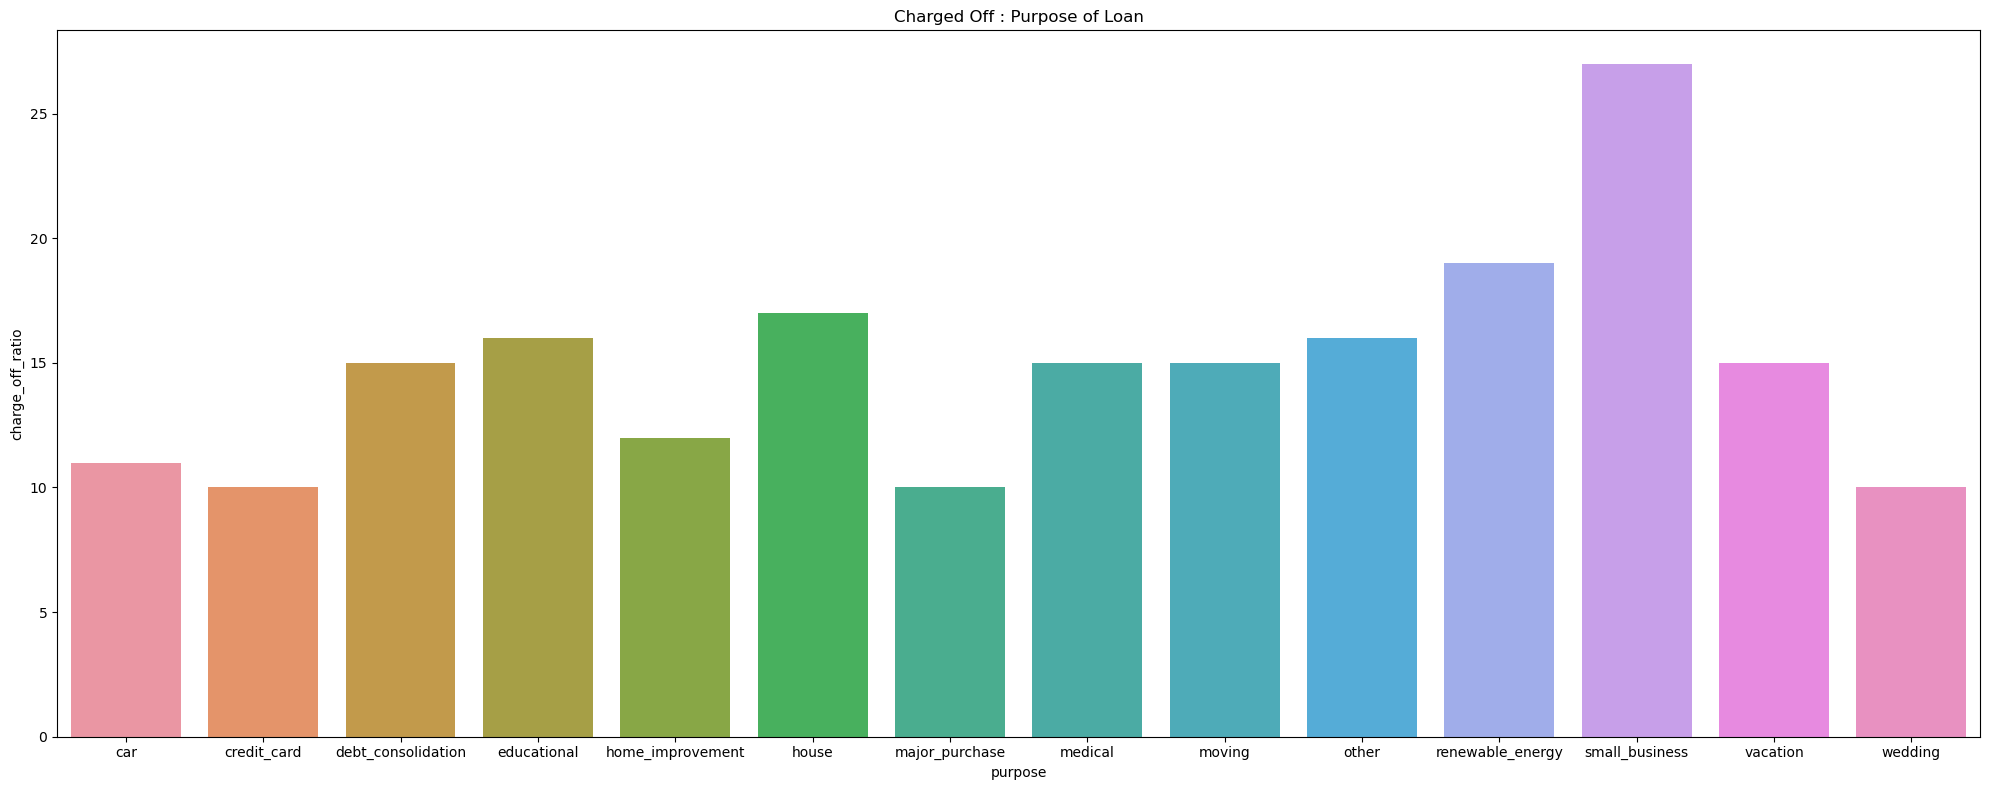

loan_status,purpose,Charged Off,Fully Paid,total,charge_off_ratio
0,car,152,1279,1431,11.0
1,credit_card,502,4299,4801,10.0
2,debt_consolidation,2628,14756,17384,15.0
3,educational,49,250,299,16.0
4,home_improvement,321,2416,2737,12.0
5,house,58,291,349,17.0
6,major_purchase,207,1854,2061,10.0
7,medical,100,547,647,15.0
8,moving,81,462,543,15.0
9,other,582,3026,3608,16.0


In [1557]:
## The ratio of Charge Offs within the category total
comparision_chart(loan, 'purpose')

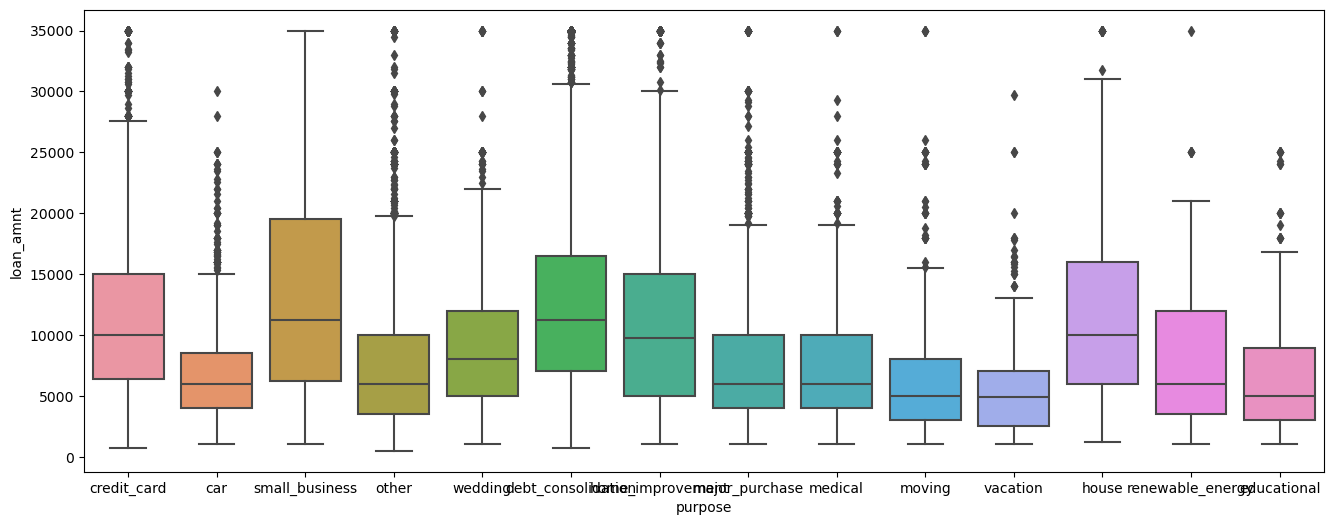

In [1558]:
plot.figure(figsize=(16,6))
sea.boxplot(y=loan.loan_amnt,x=loan.purpose)
plot.show()

# The highest risk of charge-offs is associated with the category of debt_consolidation.
# The highest probability of charge-offs within a category is found in small_business, although the volume of such loans is extremely low.
# The largest loan amounts are associated with the categories of small_business, debt_consolidation, and house.
# The greatest risk of charge-offs is linked to loans for debt_consolidation.
# Small Business applicants have a high likelihood of charge-offs, but their overall loan volume is low.
# Renewable_energy has the lowest risk of charge-offs relative to its loan volume.

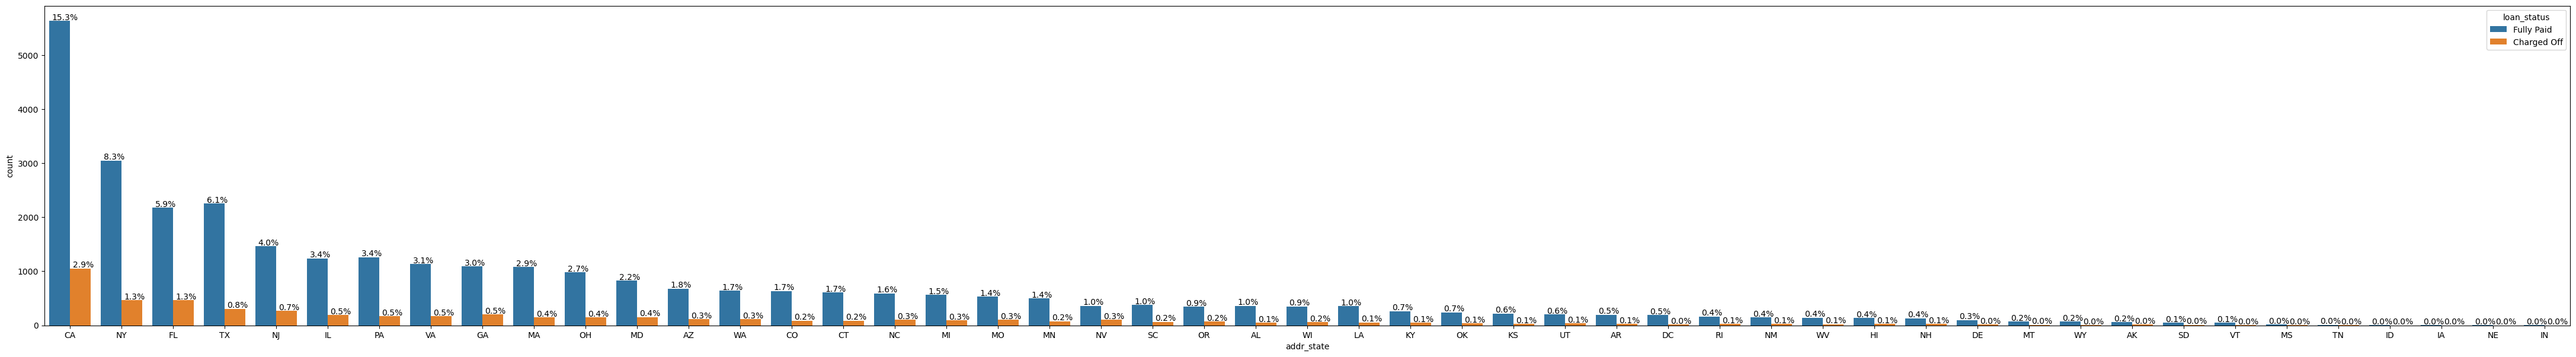

In [1559]:
# Overall ratio of Charge Offs against the total
bi_variate_func(loan, 'addr_state', 'loan_status')

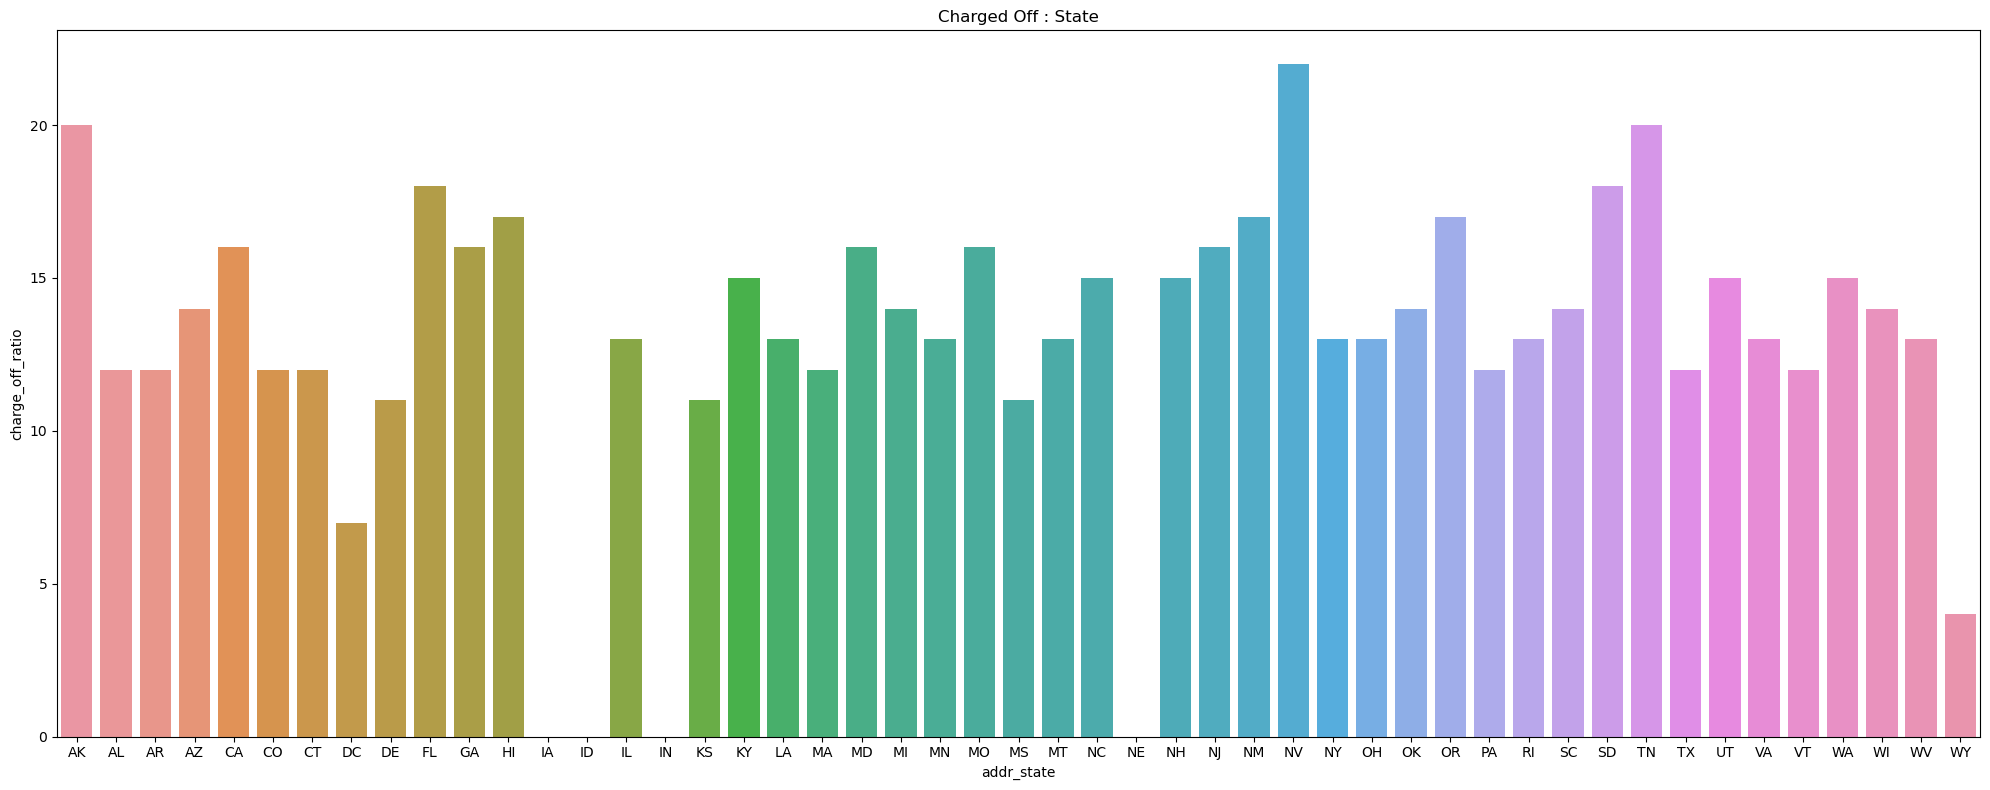

loan_status,addr_state,Charged Off,Fully Paid,total,charge_off_ratio
0,AK,15.0,60.0,75.0,20.0
1,AL,51.0,360.0,411.0,12.0
2,AR,26.0,198.0,224.0,12.0
3,AZ,114.0,680.0,794.0,14.0
4,CA,1051.0,5634.0,6685.0,16.0
5,CO,87.0,634.0,721.0,12.0
6,CT,87.0,610.0,697.0,12.0
7,DC,14.0,194.0,208.0,7.0
8,DE,12.0,96.0,108.0,11.0
9,FL,463.0,2179.0,2642.0,18.0


In [1560]:
## The ratio of Charge Offs within the category total
comparision_chart(loan, 'addr_state')

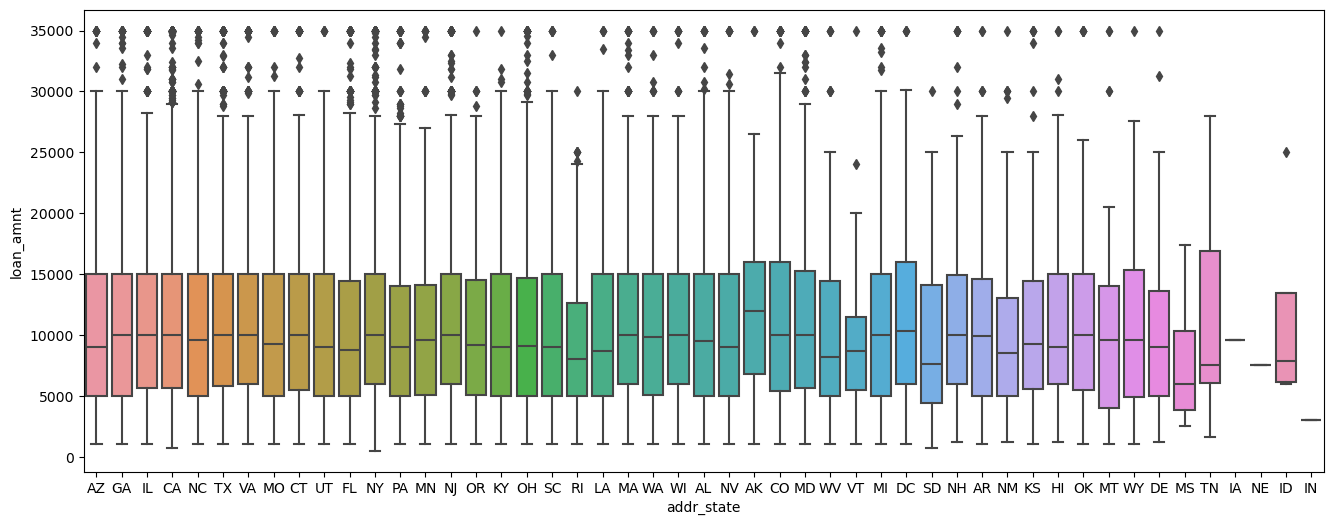

In [1561]:
plot.figure(figsize=(16,6))
sea.boxplot(y=loan.loan_amnt,x=loan.addr_state)
plot.show()

# The highest volume of loans comes from California, and based purely on volume, California also has the highest number of charge-offs.
# Within each state, Nebraska (NE) and Nevada (NV) have the highest charge-offs. However, Nebraska’s low loan volume means its data is less significant.
# Loan applications from Nevada are associated with a high risk of charge-offs.
# Loan applications from Nevada (NV) have a high risk of charge-offs.
# Nebraska (NE) has a very high probability of charge-offs, but its low loan volume limits its overall impact.
# Nevada (NV), California (CA), and Florida (FL) all show high percentages of charge-offs.

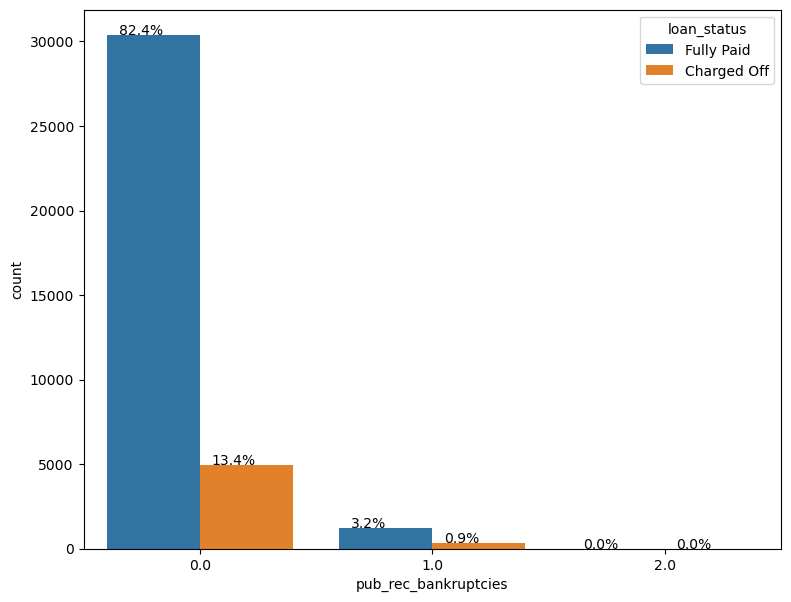

In [1562]:
# Overall ratio of Charge Offs against the total
bi_variate_func(loan, 'pub_rec_bankruptcies', 'loan_status')

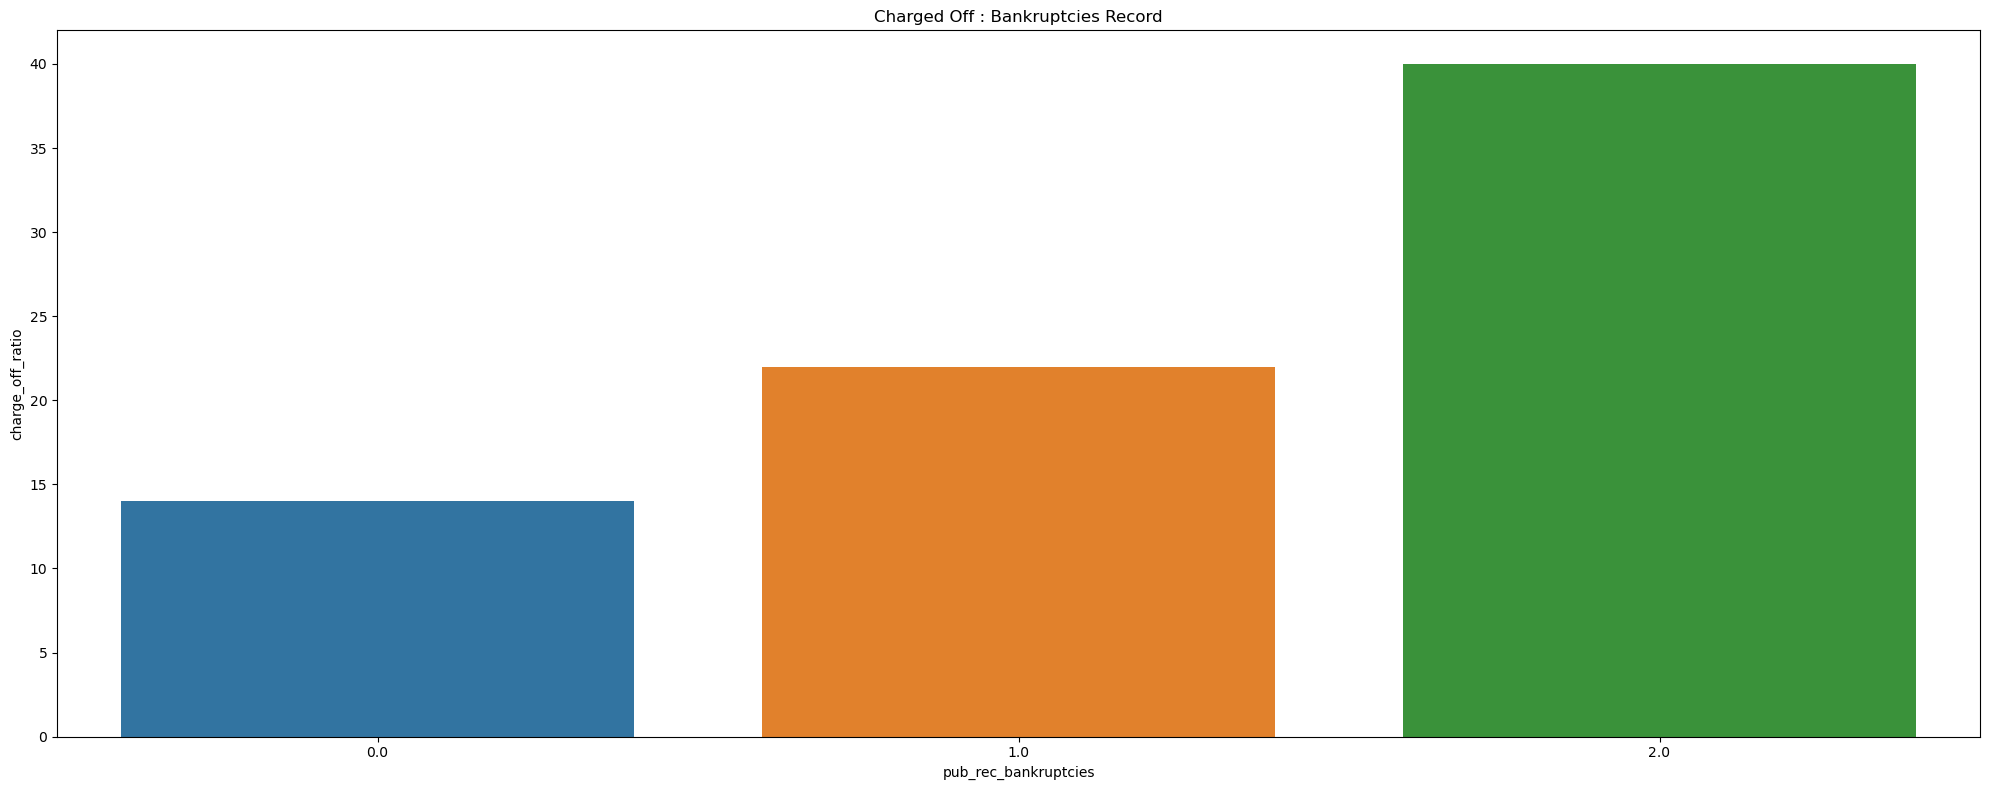

loan_status,pub_rec_bankruptcies,Charged Off,Fully Paid,total,charge_off_ratio
0,0.0,4944,30368,35312,14.0
1,1.0,335,1195,1530,22.0
2,2.0,2,3,5,40.0


In [1623]:
## The ratio of Charge Offs within the category total

comparision_chart(loan, 'pub_rec_bankruptcies')

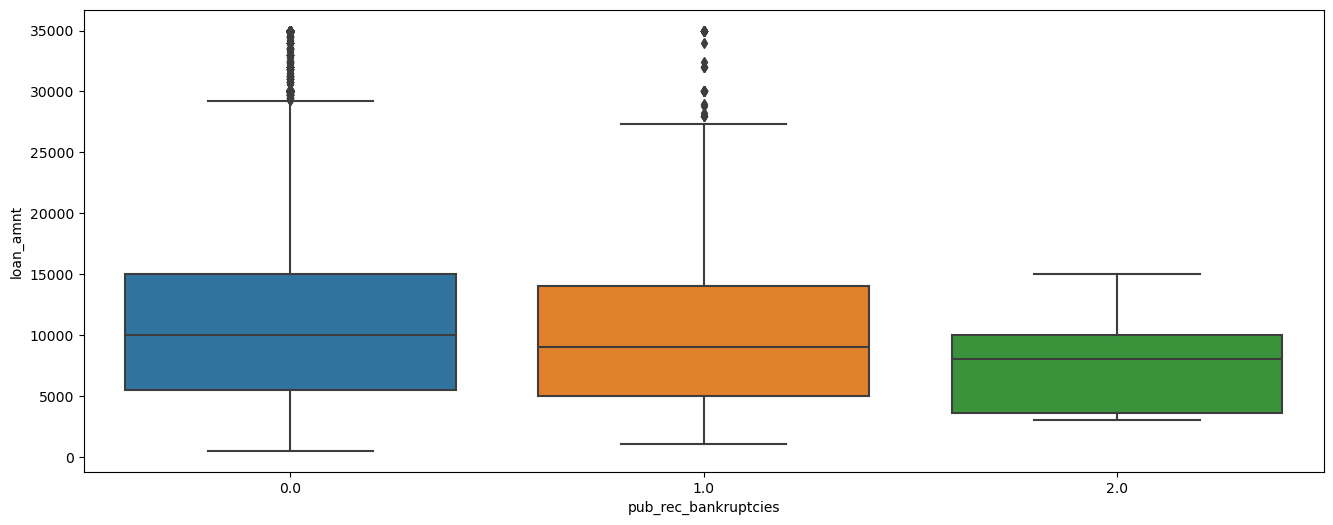

In [1625]:
plot.figure(figsize=(16,6))
sea.boxplot(y=loan.loan_amnt,x=loan.pub_rec_bankruptcies)
plot.show()

# Based purely on loan volumes, the highest number of charge-offs is observed in the category with no bankruptcy record (0).
# However, when examining charge-off ratios within each category, customers with a bankruptcy record show a higher charge-off ratio.
# Customers with a bankruptcy record are at a higher risk of charge-offs.
# Customers with a record of 2 bankruptcies have an even higher charge-off ratio.